In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Step 1: Load Data
df = pd.read_csv("merged_radiomics_metadata.csv")

# Step 2: Quantile-based survival classes
if "OS" not in df.columns:
    raise ValueError("Target column 'OS' not found in the dataset.")

df = df[df["OS"].notna()]  # Drop missing targets
quantile_classes, bins = pd.qcut(df["OS"], q=4, labels=[0, 1, 2, 3], retbins=True)
y = quantile_classes.astype(int)

print("Survival classes created based on OS quantiles:")
for i in range(4):
    print(f"Class {i}: OS in range ({bins[i]:.2f}, {bins[i+1]:.2f}]")

# Step 3: Prepare features
X = df.drop(columns=["OS", "Survival_Category", "1-dead 0-alive", "PatientID"], errors="ignore")

# Optional: Load top features from another model (e.g., importance_df)
# You need to predefine `importance_df` from your feature importance step
# Uncomment this block if you have importance_df:
# top_100_features = importance_df.head(100)['Feature'].tolist()
# X = X[top_100_features]

# Step 4: Encode categoricals
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Step 5: Handle missing values
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Step 6: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute LDA importance scores
lda_for_importance = LinearDiscriminantAnalysis()
lda_for_importance.fit(X_scaled, y)

# Importance: Sum of absolute coefficients across components
lda_importance = np.abs(lda_for_importance.coef_).sum(axis=0)

# Map to feature names
feature_importance = pd.Series(lda_importance, index=X.columns).sort_values(ascending=False)

# Select top 100 features
top_100_features = feature_importance.head(95).index.tolist()

# Reduce X and rescale
X = X[top_100_features]
X_scaled = scaler.fit_transform(X)  # Re-standardize

# Step 7: Dimensionality Reduction with LDA
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_scaled, y)

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.1, random_state=42, stratify=y)

# Step 9: Balance training data with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Step 10: Define models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, use_label_encoder=False, eval_metric="mlogloss", random_state=42)
log_reg = LogisticRegression(max_iter=1000)
lda_clf = LinearDiscriminantAnalysis()

# Voting Classifier (Soft Voting)
ensemble_model = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    voting="soft"
)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    final_estimator=RandomForestClassifier()
)

# Step 11: Train Models
print("\nTraining models...")
ensemble_model.fit(X_train, y_train)
stacking_clf.fit(X_train, y_train)

# Step 12: Predict
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Step 13: Evaluate
print("\n🔎 Ensemble Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble):.2f}")
print(classification_report(y_test, y_pred_ensemble))

print("\n🔎 Stacking Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stacking):.2f}")
print(classification_report(y_test, y_pred_stacking))


Survival classes created based on OS quantiles:
Class 0: OS in range (13.00, 181.75]
Class 1: OS in range (181.75, 414.00]
Class 2: OS in range (414.00, 812.75]
Class 3: OS in range (812.75, 2209.00]

Training models...


d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=o


🔎 Ensemble Model Evaluation:
Accuracy: 0.91
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00         5
           2       0.83      0.83      0.83         6
           3       0.83      1.00      0.91         5

    accuracy                           0.91        22
   macro avg       0.92      0.92      0.91        22
weighted avg       0.92      0.91      0.91        22


🔎 Stacking Model Evaluation:
Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      1.00      1.00         5
           2       1.00      0.83      0.91         6
           3       0.67      0.80      0.73         5

    accuracy                           0.86        22
   macro avg       0.88      0.87      0.87        22
weighted avg       0.88      0.86      0.87        22



In [28]:
# Midpoints of survival bins
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Approximate survival time from predicted labels
pred_survival = [bin_midpoints[int(label)] for label in y_pred_ensemble]
true_survival = df.loc[y_test.index, "OS"]

from lifelines.utils import concordance_index
c_index = concordance_index(true_survival, pred_survival)
print(f"✅ Concordance Index (approx): {c_index:.4f}")


✅ Concordance Index (approx): 0.8658


✅ Confusion Matrix:
[[5 0 1 0]
 [0 5 0 0]
 [0 0 5 1]
 [0 0 0 5]]


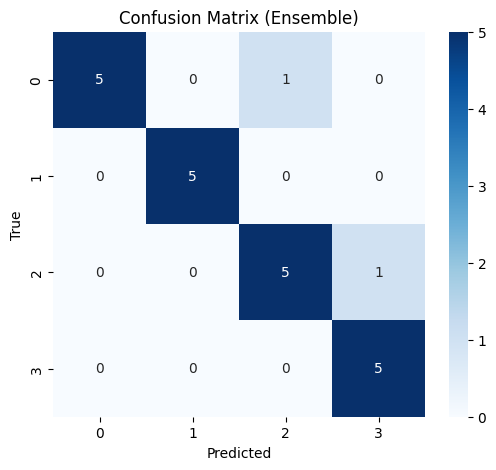


✅ Balanced Accuracy: 0.9167

✅ ROC-AUC (Macro): 0.9710
✅ ROC-AUC (Micro): 0.9766

✅ Concordance Index (approx. from predicted class): 0.8658


In [29]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred_ensemble)
print("✅ Confusion Matrix:")
print(cm)

# Optional: Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Ensemble)")
plt.show()

# BALANCED ACCURACY
bal_acc = balanced_accuracy_score(y_test, y_pred_ensemble)
print(f"\n✅ Balanced Accuracy: {bal_acc:.4f}")

# ROC-AUC SCORE (macro & micro)
# First, binarize labels for multiclass AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_proba = ensemble_model.predict_proba(X_test)

# Handle cases where classifier is not probabilistic
if isinstance(y_proba, list):  # If VotingClassifier gives a list per estimator
    y_proba = np.mean([p for p in y_proba], axis=0)

roc_auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test_bin, y_proba, average='micro', multi_class='ovr')

print(f"\n✅ ROC-AUC (Macro): {roc_auc_macro:.4f}")
print(f"✅ ROC-AUC (Micro): {roc_auc_micro:.4f}")

# CONCORDANCE INDEX
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]
pred_survival = [bin_midpoints[int(label)] for label in y_pred_ensemble]
true_survival = df.loc[y_test.index, "OS"]

c_index = concordance_index(true_survival, pred_survival)
print(f"\n✅ Concordance Index (approx. from predicted class): {c_index:.4f}")


Classification structure below

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Step 1: Load merged data
df = pd.read_csv('merged_radiomics_metadata.csv')

# Step 2: Define features (X) and create quantile-based classes from "OS"
if "OS" not in df.columns:
    raise ValueError("Target column 'OS' not found in the dataset.")

df = df[df["OS"].notna()]  # Drop rows with missing OS
# Create 4 quantile-based classes for OS
quantile_classes, bins = pd.qcut(df["OS"], q=4, labels=[0, 1, 2, 3], retbins=True)
y = quantile_classes.astype(int)

# Print class info
print("Survival classes created based on OS quantiles:")
for i in range(4):
    print(f"Class {i}: OS in range ({bins[i]:.2f}, {bins[i+1]:.2f}]")

# Drop target and irrelevant columns from features
X = df.drop(columns=["OS", "Survival_Category", "1-dead 0-alive"], errors="ignore")

# Step 3: Encode categorical features
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Step 4: Handle missing values
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Step 5: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 6: Apply LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=None)  # Auto: will reduce to n_classes - 1 (3 for 4 classes)
X_lda = lda.fit_transform(X_scaled, y)
print(f"\nLDA-reduced feature shape: {X_lda.shape}")

# Step 7: Apply SMOTE to balance classes
print("\nClass distribution before SMOTE:\n", y.value_counts())
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_lda, y)
print("Class distribution after SMOTE:\n", pd.Series(y_smote).value_counts())

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.3, stratify=y_smote, random_state=42
)

# Step 9: Define base models
rf = RandomForestClassifier(n_estimators=15, max_depth=8, random_state=42)
xgb_clf = xgb.XGBClassifier(
    n_estimators=10, max_depth=3, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.8, use_label_encoder=False,
    eval_metric='mlogloss', random_state=42
)
logreg = LogisticRegression(max_iter=500)

# Step 10: Define ensemble models
voting = VotingClassifier(estimators=[
    ("rf", rf), ("xgb", xgb_clf), ("logreg", logreg)
], voting="soft")

stacking = StackingClassifier(
    estimators=[("rf", rf), ("xgb", xgb_clf), ("logreg", logreg)],
    final_estimator=LogisticRegression(max_iter=100)
)

# Step 11: Train and evaluate
print("\n🔧 Training Voting Classifier...")
voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)
print("\nVoting Classifier Report:")
print(classification_report(y_test, y_pred_voting))

print("\n🔧 Training Stacking Classifier...")
stacking.fit(X_train, y_train)
y_pred_stacking = stacking.predict(X_test)
print("\nStacking Classifier Report:")
print(classification_report(y_test, y_pred_stacking))


Survival classes created based on OS quantiles:
Class 0: OS in range (13.00, 181.75]
Class 1: OS in range (181.75, 414.00]
Class 2: OS in range (414.00, 812.75]
Class 3: OS in range (812.75, 2209.00]

LDA-reduced feature shape: (216, 3)

Class distribution before SMOTE:
 OS
3    54
0    54
2    54
1    54
Name: count, dtype: int64
Class distribution after SMOTE:
 OS
3    54
0    54
2    54
1    54
Name: count, dtype: int64

🔧 Training Voting Classifier...


d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:32:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:32:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:32:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\mlpr data\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:32:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=o


Voting Classifier Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.94      1.00      0.97        16
           2       1.00      0.82      0.90        17
           3       0.94      1.00      0.97        16

    accuracy                           0.95        65
   macro avg       0.96      0.96      0.95        65
weighted avg       0.96      0.95      0.95        65


🔧 Training Stacking Classifier...

Stacking Classifier Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.94      1.00      0.97        16
           2       1.00      0.82      0.90        17
           3       0.94      1.00      0.97        16

    accuracy                           0.95        65
   macro avg       0.96      0.96      0.95        65
weighted avg       0.96      0.95      0.95        65



In [5]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc_voting = balanced_accuracy_score(y_test, y_pred_voting)
balanced_acc_stacking = balanced_accuracy_score(y_test, y_pred_stacking)

print(f"\nBalanced Accuracy (Voting): {balanced_acc_voting:.4f}")
print(f"Balanced Accuracy (Stacking): {balanced_acc_stacking:.4f}")



Balanced Accuracy (Voting): 0.9559
Balanced Accuracy (Stacking): 0.9559


In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Predict probabilities
y_proba_voting = voting.predict_proba(X_test)
y_proba_stacking = stacking.predict_proba(X_test)

# Compute AUC-ROC (macro-average)
roc_auc_voting = roc_auc_score(y_test_bin, y_proba_voting, average='macro', multi_class='ovr')
roc_auc_stacking = roc_auc_score(y_test_bin, y_proba_stacking, average='macro', multi_class='ovr')

print(f"\nAUC-ROC (Voting): {roc_auc_voting:.4f}")
print(f"AUC-ROC (Stacking): {roc_auc_stacking:.4f}")



AUC-ROC (Voting): 0.9991
AUC-ROC (Stacking): 0.9988


In [ ]:
from lifelines.utils import concordance_index

# Step 1: Align true survival times from original df using y_test indices
true_survival_times = df.loc[y_test.index, "OS"]

# Step 2: Define bin midpoints (from earlier quantile binning)
# Ensure `bins` is defined earlier in your pipeline when you binned the "OS" column
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Step 3: Map predicted class labels to survival time estimates
pred_survival_voting = [bin_midpoints[int(label)] for label in y_pred_voting]
pred_survival_stacking = [bin_midpoints[int(label)] for label in y_pred_stacking]

# Step 4: Compute Concordance Index
c_index_voting = concordance_index(true_survival_times, pred_survival_voting)
c_index_stacking = concordance_index(true_survival_times, pred_survival_stacking)

# Step 5: Print results
print(f"Concordance Index (Voting): {c_index_voting:.4f}")
print(f"Concordance Index (Stacking): {c_index_stacking:.4f}")

Concordance Index (Voting): 0.5465
Concordance Index (Stacking): 0.5465
